# Jump-Diffusion Implied Volatility

We consider the followeing risk-neutral SDE for the log-price of an underlying asset:

$d\ln\left(S_t\right) = \left(r + \nu -\frac{\sigma^2}{2}\right)dt + \sigma dW_t + \ln(Y_t)dN_t$, 

where $W_t$ is a $\mathbb{Q}\text{-Brownian Motion}$: $W_t^\mathbb{Q} \sim N(0, t)$,

$\ln(Y_t) \sim N(\alpha,\;\beta^2)$, 

$dN_t \sim\text{Pois}(\lambda dt)$,

and $\nu = -\lambda(\mathbb{E}Y_t -1)$

We use 20,000 Monte Carlo samples to price a European call option with $S_0=100$, $r=0.05$, $\sigma=0.3$, $T=1/12$ and strikes $K=90 : 120$.
    We take the jump parameters to be $\beta=0.1$, and we adjust $\lambda$ and $\alpha$ to be: $\lambda \in \{2, 5\}$ and $\alpha\in \{-0.1, 0.1\}$, so that we get 2 x 2 different option curves.

In simulating the SDEs, we take a step size of $\Delta t =\frac{1}{4*365}$ and we compare the implied volatility smiles for different $(\lambda, \alpha)$ pairs by plotting a (2 x 2) subplot, with the horizontal axis being in units of moneyness.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import *

### Initial Parameters setup

In [2]:
M = 20000 # Number of Monte Carlo samples
sigma = 0.3
S0 = 100
r = 0.05
T= 1 / 12
K = np.arange(90, 121)
lamda = 5
a = 0.1
b = 0.1
dt = (1 / (4 * 365))
n = round(T / dt)
disc = exp(-r * T)

### Euler-Maruyama to simulate the Jump-Diffusion SDE

Since $\ln Y_t \sim N(\alpha, \beta^2)\implies\;Yt\sim lognormal\left[e^{\alpha+0.5\beta^2}, e^{2\alpha+\beta^2}\left(e^{\sigma^2}-1\right)\right]$, and so $\mathbb{E}Y_t = e^{\alpha+0.5\beta^2}$.

In [3]:
nu = -lamda * (exp(a + 0.5 * (b **2)) -1)

# Empty array to store the log-price at each time node
X = log(S0) * np.ones((M,n))

# Sample the jump random variables
log_Y = np.random.normal(a, b ** 2, (M, n))
dN = np.random.poisson(lamda * dt, (M, n))

# Sample a (M x n) Standard Brownian Motion
dW = np.random.normal(0, 1, (M, n)) * sqrt(dt)

# Simulate the SDE
for i in range(1, n): 
    
    # Compute the jump variable
    jump = log_Y[:, i - 1] * np.sqrt(dN[:, i - 1])
    X[:, i] = X[:, i - 1] + (r + nu - 0.5 * (sigma**2)) * dt + (sigma * dW[:, i - 1]) + jump
    
# Exponentiate to obtain the underlying price
S = np.exp(X)

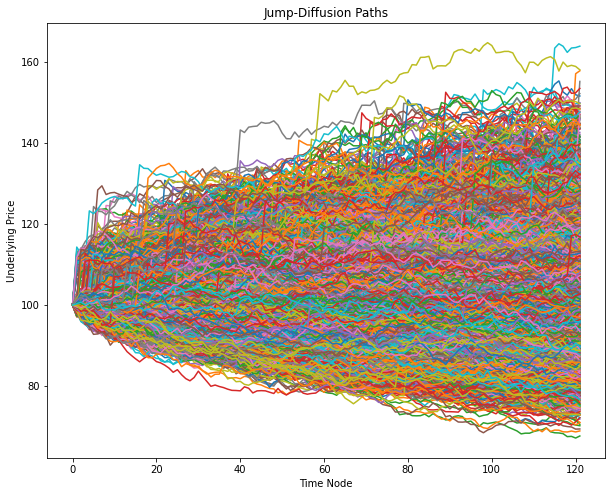

In [4]:
# Plot the Monte Carlo underlying asset paths
plt.figure(figsize=(10 , 8))
plt.plot(S.T)
plt.xlabel("Time Node")
plt.ylabel("Underlying Price")
plt.title("Jump-Diffusion Paths")
plt.show()

### Pricing varying options curves according to different jump-diffusion calibrations

In [5]:
lamda_list = [2, 5]
alpha_list = [-0.1, 0.1]
# Empty list to store the call prices
call_prices = []
for lamda in lamda_list:
    for a in alpha_list:
        # Set seed
        np.random.seed(919702)
        
        nu = -lamda * (exp(a + 0.5 * (b **2)) -1)
        
        # Empty array to store the log-price at each time node
        X = log(S0) * np.ones((M,n))

        # Sample the jump random variables
        log_Y = np.random.normal(a, b ** 2, (M, n))
        dN = np.random.poisson(lamda * dt, (M, n))

        # Sample a (M x n) Standard Brownian Motion
        dW = np.random.normal(0, 1, (M, n)) * sqrt(dt)

        # Simulate the SDE
        for i in range(1, n): 
            # Compute the jump variable
            jump = log_Y[:, i - 1] * np.sqrt(dN[:, i - 1])
            X[:, i] = X[:, i - 1] + (r + nu - 0.5 * (sigma**2)) * dt + (sigma * dW[:, i - 1]) + jump

        # Exponentiate to obtain the underlying price
        S = np.exp(X)
        # Extract the terminal asset values from all the Monte Carlo paths
        S_last = S[:, -1]
        # Create the (Strikes x Terminal Values) grid
        [S_terminal, Kn] = np.meshgrid(S_last, K)
        final_payoff = np.maximum(S_terminal - Kn, 0)
        # European option price is the discounted expectation of the final payoff under a risk-neutral probability measure
        call_price = disc * (final_payoff.mean(axis=1))
        call_prices.append(call_price)

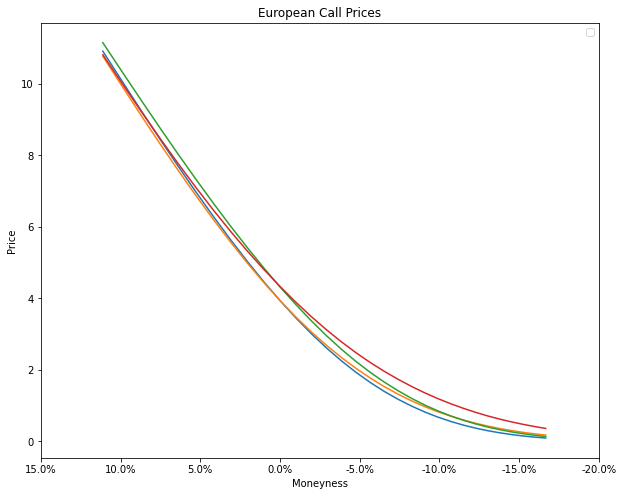

In [6]:
# Collect the call curves and transform them in a dataframe 
moneyness = (S0 - K) / K
calls = pd.DataFrame(np.array(call_prices).T, index=K)
calls.set_index(moneyness).plot(figsize=(10, 8))
plt.gca().invert_xaxis()
plt.legend("")
plt.xlabel("Moneyness")
plt.ylabel("Price")
plt.title("European Call Prices")
xticks = plt.xticks()[0]
xlabs = [str(round(100 * tick,2)) + "%" for tick in xticks]
plt.xticks(ticks=xticks, labels=xlabs)
plt.show()

### Volatility Smiles for varying Jump-Diffusion calibrations

In [7]:
from py_vollib_vectorized.implied_volatility import vectorized_implied_volatility as imp_vol_bs

In [8]:
# Empty dataframe to store the volatility smiles
vol_smiles = pd.DataFrame()
for i in range(calls.shape[1]):
    vol_smile = imp_vol_bs(calls.iloc[:, i], S0, K, T, r, flag="c", q=0)
    vol_smiles = pd.concat([vol_smiles, vol_smile], axis=1)
vol_smiles.set_index(moneyness, inplace=True)
vol_smiles.index.rename("Moneyness", inplace=True)

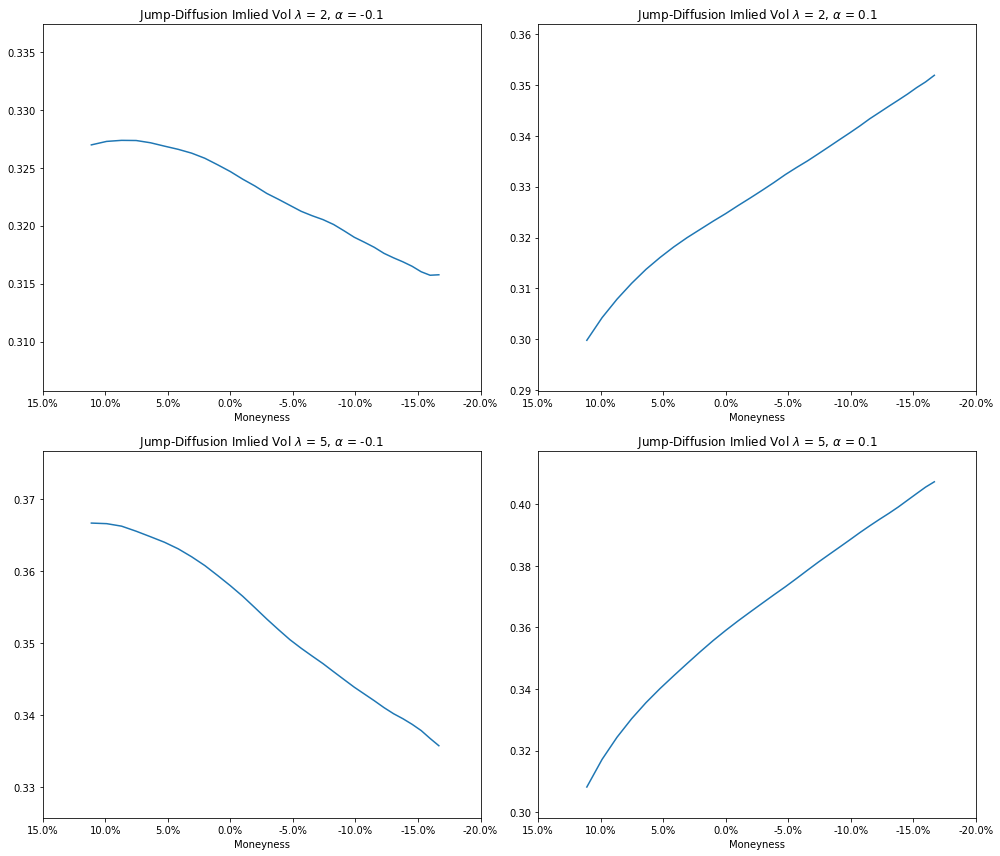

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(14, 12))
axs = axs.flatten()
lamda_param = np.tile(np.array(lamda_list).reshape(-1, 1), 2).flatten()
alpha_param = np.tile(np.array(alpha_list), 2).flatten()
for i, ax in enumerate(axs):
    vol_smiles.iloc[:, i].plot(ax=ax)
    ax.invert_xaxis()
    ax.set_ylim(vol_smiles.iloc[:, i].min() - 0.01, vol_smiles.iloc[:, i].max() + 0.01)
    ax.set_title("Jump-Diffusion Imlied Vol " + r"$\lambda$ = " + str(lamda_param[i]) + r", $\alpha$ = " +str(alpha_param[i]))
    ax.set_xticks(ticks=ax.get_xticks(), labels=xlabs)
plt.tight_layout()
plt.show()

### Effect of the Jump-Diffusion calibration on capturing the Volatility Smile

**1. <u>Effect of the instantaneous mean jump-rate $\lambda$ on the Smile**

 The instantaneous mean jump-rate parameter controls the overall level of the smile, with higher values leading to higher levels of implied vol.


**2. <u>Effect of the jump parameter $\alpha$ on the Smile**
    
 The jump parameter $\alpha$ controls the smile’s skew: when $\alpha  < 0$, the smile is left-skewed. When $ \alpha > 0$, the smile is right-skewed.